# Mesa Testing

In this notebook we test and develop the needed classes that are going to be used in the eventual P2P-energy trading simulation.

In [1]:
from scripts.utils import generate_household_dataframe, generate_grid_prize_data
from scripts.model import MicroGrid
from scripts.results import show_sim_report, energy_delta_per_agent, grid_prize_vs_local_prize, impact_of_battery_usage

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Generating the data

In the next cell we will define the profile ratios that are being used to generate the consumption data per household. By defining the profile ratio's, we can see if different ratio's and attributes of people will impact the overal pricing of energy.

In [2]:
profile_ratios = {
    'early_bird': 0.2,
    'evening_person': 0.3,
    'base_profile': 0.4,
    'energy_saver': 0.1
}

Now we will use our generation functions and a csv file to make three different datasets:

#### Household consumption

This dataset holds information about the hours people use household appliances and electronics. There are columns for the hours, the ID number and the profile each household belongs to. The index of the dataset holds the day.

#### Solar strength per hour (for solar panel energy production)

This dataset holds information about the levels of solar strength (in W/m2) per hour of each day. Here the columns represent the hours and the index holds the days.

#### Grid price data

This dataset holds information about the price of the grid energy. This is based of a scaling that holds in account when it is summer and has a slowly decreasing trend, just like we see in the [CBS Dataset](https://www.cbs.nl/nl-nl/cijfers/detail/85592NED) about energy prices for consumers.

In [3]:
# Creating the dataframes for the simulation
household_prosumption_data = generate_household_dataframe(
    n_days=366,
    n_households=30,
    profile_ratios=profile_ratios,
    seed=42
    )

production_data = pd.read_csv("data/solar_strength.csv", index_col="DATE")

grid_price_data = generate_grid_prize_data(
    n_days=366,
    seed=42
    )

## Initialising the MicroGrid

Now we will start up our MicroGrid for simulation purposes. Using several different hyperparameters, we can tune the simulation to our liking. This allows us to test different scenario's with ease, by tuning elements like:
- The amount of solar panels, their distribution and their effectiveness.
- The properties of the battery.
- The amount of households on the grid.

In [4]:
# Initialising the simulation
simulation = MicroGrid(
    n_households=30, # Number of Agents, cannot be higher than the amount of Agents in the dataframe
    consumption_data=household_prosumption_data,
    production_data=production_data,
    grid_prize_data=grid_price_data,
    gini=0.1,
    mean_panels=8,
    panel_efficiency=0.2,
    bat_capacity=500,
    bat_c_rate=0.5,
    bat_efficiency=0.9,
    seed=42
)

Now we can run our simulation by using the long_step method from the class. This method takes one argument, the amount of iterations the simulation will make (n). In order to do this correctly for our model, you will need to fill in the amount of days multiplied by 24 (amount of hours in each day). This is due to our model making steps every hour. In case you want two years you cna multiply it by 2 and so forth. Worth noting is that we start in 2024 by default, which is a leap year.

In [5]:
simulation.long_step(n=365*24)

[DAILY PRICE UPDATE :: 02-01-2024]: Price: 0.1905 | Grid Price: 0.1976 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 03-01-2024]: Price: 0.1925 | Grid Price: 0.1972 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 04-01-2024]: Price: 0.1938 | Grid Price: 0.1969 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 05-01-2024]: Price: 0.1948 | Grid Price: 0.1971 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 06-01-2024]: Price: 0.1954 | Grid Price: 0.1967 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 07-01-2024]: Price: 0.1956 | Grid Price: 0.1963 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 08-01-2024]: Price: 0.1958 | Grid Price: 0.1962 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 09-01-2024]: Price: 0.1951 | Grid Price: 0.1951 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 10-01-2024]: Price: 0.1950 | Grid Price: 0.1950 | Battery charge level: 0.00
[DAILY PRICE UPDATE :: 11-01-2024]: Price: 0.1952 | Grid Price: 0.1956 | Battery charge level: 0.00


## Converting the data

The data retrieved from the model is currently in dictionaries. Luckily, we are easily able to change these to dataframes.

In [6]:
simulation._convert_to_dataframe()

sim_df = simulation.sim_df.copy()
agent_df = simulation.agent_df.copy()

Now we can show the first few rows for each dataframe.

In [7]:
print("Displaying the simulation data:")
display(sim_df.head())

print("Displaying the agent data:")
display(agent_df.head())

Displaying the simulation data:


,day,hour,grid_price,local_price,market_pressure,microgrid_demand,microgrid_supply,energy_delta,battery_state
0,01-01-2024,0,0.1974,0.1874,NaN,2.669802,0.0,-2.669802,0.0
1,01-01-2024,1,0.1974,0.1874,NaN,2.617553,0.0,-2.617553,0.0
2,01-01-2024,2,0.1974,0.1874,NaN,2.642785,0.0,-2.642785,0.0
3,01-01-2024,3,0.1974,0.1874,NaN,2.617604,0.0,-2.617604,0.0
4,01-01-2024,4,0.1974,0.1874,NaN,2.627173,0.0,-2.627173,0.0


Displaying the agent data:


,day,hour,agent_id,profile,solarpanel_area,consumed,produced,traded,earnings
0,01-01-2024,0,20,early_bird,8.5,0.099890,0.0,0.0,0.0
1,01-01-2024,0,15,base_profile,8.2,0.085670,0.0,0.0,0.0
2,01-01-2024,0,11,evening_person,7.9,0.093049,0.0,0.0,0.0
3,01-01-2024,0,27,base_profile,8.8,0.102280,0.0,0.0,0.0
4,01-01-2024,0,23,early_bird,8.6,0.082842,0.0,0.0,0.0


## Result interpretation

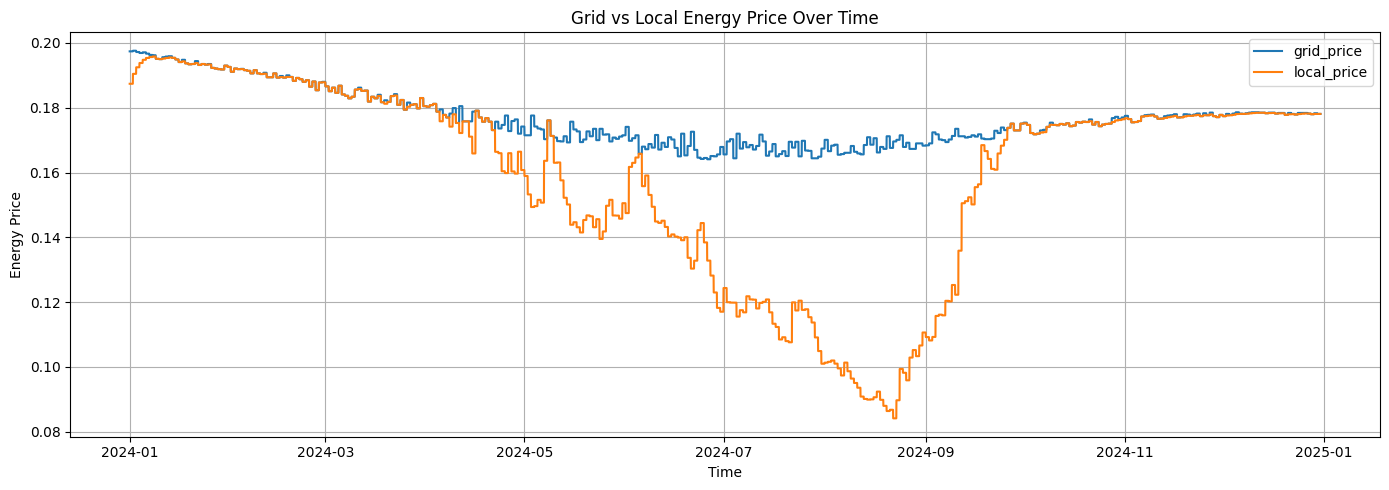

In [9]:
grid_prize_vs_local_prize(simulation.sim_df)

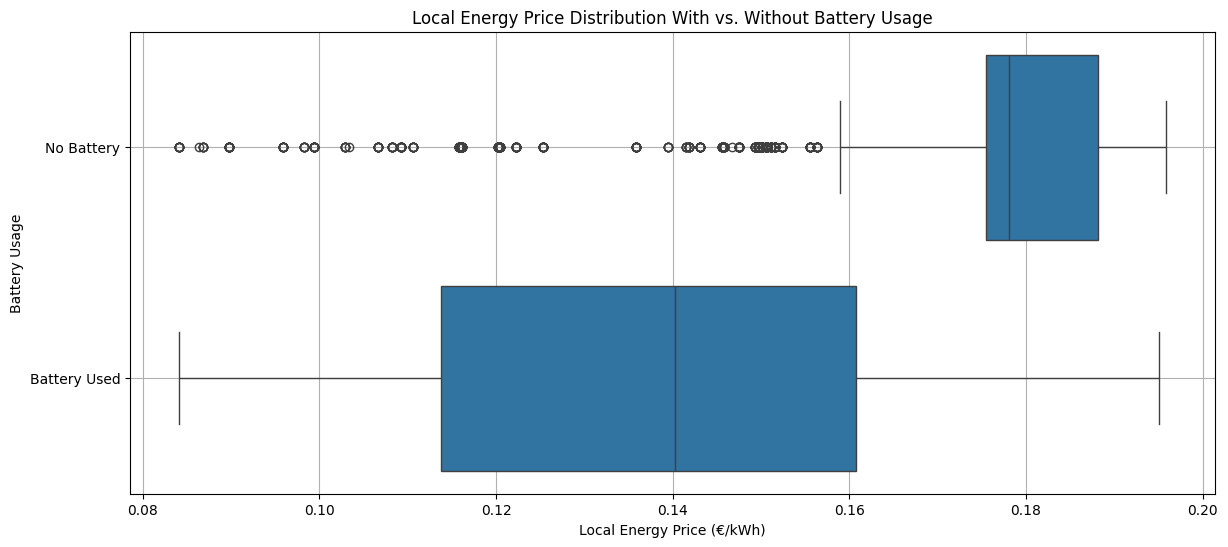

In [10]:
impact_of_battery_usage(simulation.sim_df)

In [28]:
def energy_delta_per_agent(agent_df):
    agent_summary = agent_df.groupby("agent_id").agg({
        "profile": "first",
        "produced": "sum",
        "consumed": "sum"
    }).reset_index()
    agent_summary["net_balance"] = agent_summary["produced"] \
        - agent_summary["consumed"]

    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=agent_summary.sort_values("net_balance"),
        x="agent_id", y="net_balance", palette="viridis",
        hue="profile"
        )
    plt.axhline(0, color='black', linestyle='--')
    plt.title("Net Energy Balance Per Agent (Produced - Consumed)")
    plt.xlabel("Agent ID")
    plt.ylabel("Net Energy Balance (kWh)")
    plt.tight_layout()
    plt.show()

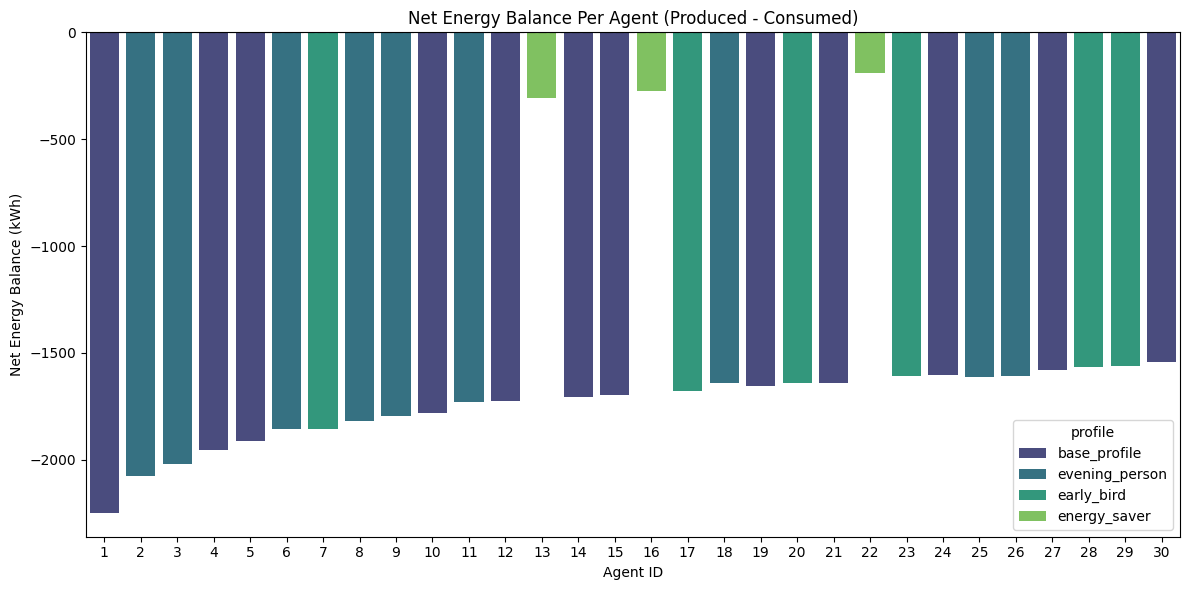

In [29]:
energy_delta_per_agent(simulation.agent_df)

In [18]:
show_sim_report(simulation, profile_ratios)


        Details of the simulation:

          Parameters:
          ---------------------------------------------------

          - Number of Households:   30
          - Gini:                   0.1
          - Mean panels:            8
          - Panel efficiency:       0.2
          - Battery capacity:       500
          - Battery charge rate:    0.5
          - Battery efficiency:     0.9
          - Number of days:         365


          Profiles used:
          ---------------------------------------------------
          - early_bird: ratio = 0.2
          - base_profile: ratio = 0.4
          - evening_person: ratio = 0.3
          - energy_saver: ratio = 0.1


          Results:
          ---------------------------------------------------

            Energy statistics:
            -------------------------------------------------
            - Total demand:             70068.68776381861
            - Total supply:             28247.989460038574
            - Average ener